In [36]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib import patheffects
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
import xarray as xr
from metpy.interpolate import cross_section


In [37]:
# Open each dataset from 00 to 09Z of ERA5 Re; change name accordingly to yours
ds1 = xr.open_dataset('ua_Amon_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_20600116-21000516_v20190710.nc')#ua_Amon_CIESM_ssp585_r1i1p1f1_gr_20600116-21000516_v20200605.nc')
ds1 = ds1.metpy.parse_cf().squeeze()
ds2 = xr.open_dataset('va_Amon_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_20600116-21000516_v20190710.nc')#va_Amon_CIESM_ssp585_r1i1p1f1_gr_20600116-21000516_v20200605.nc')
ds2 = ds2.metpy.parse_cf().squeeze()
#ds3 = xr.open_dataset('EU_VCS_06.nc')
#ds3 = ds3.metpy.parse_cf().squeeze()
#ds4 = xr.open_dataset('EU_VCS_09.nc')
#ds4 = ds4.metpy.parse_cf().squeeze()

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


In [38]:
# Grab lat/lon values (NAM will be 2D)
lats = ds1.lat
lons = ds1.lon
lev = ds1.plev

# Select and grab data
#mslp = ds['msl']
#div = ds1['d']
u_wind = ds1['ua']
v_wind = ds2['va']

# Select U and V-components at 850 hPa
uwnd_850 = gaussian_filter(u_wind.sel(plev=85000).data[0], sigma=1.0) * units('m/s')
vwnd_850 = gaussian_filter(v_wind.sel(plev=85000).data[0], sigma=1.0) * units('m/s')

# Select U and V-components at 400 hPa
uwnd_400 = gaussian_filter(u_wind.sel(plev=20000).data[0], sigma=1.0) * units('m/s')
vwnd_400 = gaussian_filter(v_wind.sel(plev=20000).data[0], sigma=1.0) * units('m/s')

# Calculate U and V-wind shear components
uwnd_shear = uwnd_850 - uwnd_400
vwnd_shear = vwnd_850 - vwnd_400

# Transform m/s into knots
uwnd_kt = uwnd_shear.to('kt')
vwnd_kt = vwnd_shear.to('kt')

# Select and grab MSLP
#mslp_surf = gaussian_filter(mslp.data[1], sigma=3.0) * units.pascal
#mslp_hpa = mslp_surf.to(units.hectopascal)

#diverge = gaussian_filter(div.sel(level=600).data[0], sigma=3.0) * units('s**-1')

#vtime = datetime.strptime(str(ds1.time.data[0].astype('datetime64[ms]')),
#                          '%Y-%m-%dT%H:%M:%S.%f')

In [39]:
uwnd_850

Magnitude,[[5.532924652099609 5.594536304473877 5.724488258361816 ... 8.165481567382812 8.16280746459961 8.200095176696777] [6.979198455810547 7.091658115386963 7.282285690307617 ... 9.689977645874023 9.688702583312988 9.71734619140625] [9.163989067077637 9.334185600280762 9.58281135559082 ... 11.69418716430664 11.704567909240723 11.72252368927002] ... [-3.3596444129943848 -3.478321075439453 -3.7258071899414062 ... -1.2863898277282715 -2.047304391860962 -2.5202527046203613] [-4.601892948150635 -4.6210479736328125 -4.697347640991211 ... -3.550111770629883 -4.242076873779297 -4.66394567489624] [-5.37037992477417 -5.332100868225098 -5.311770915985107 ... -5.1590704917907715 -5.808043479919434 -6.215183258056641]]
Units,meter/second


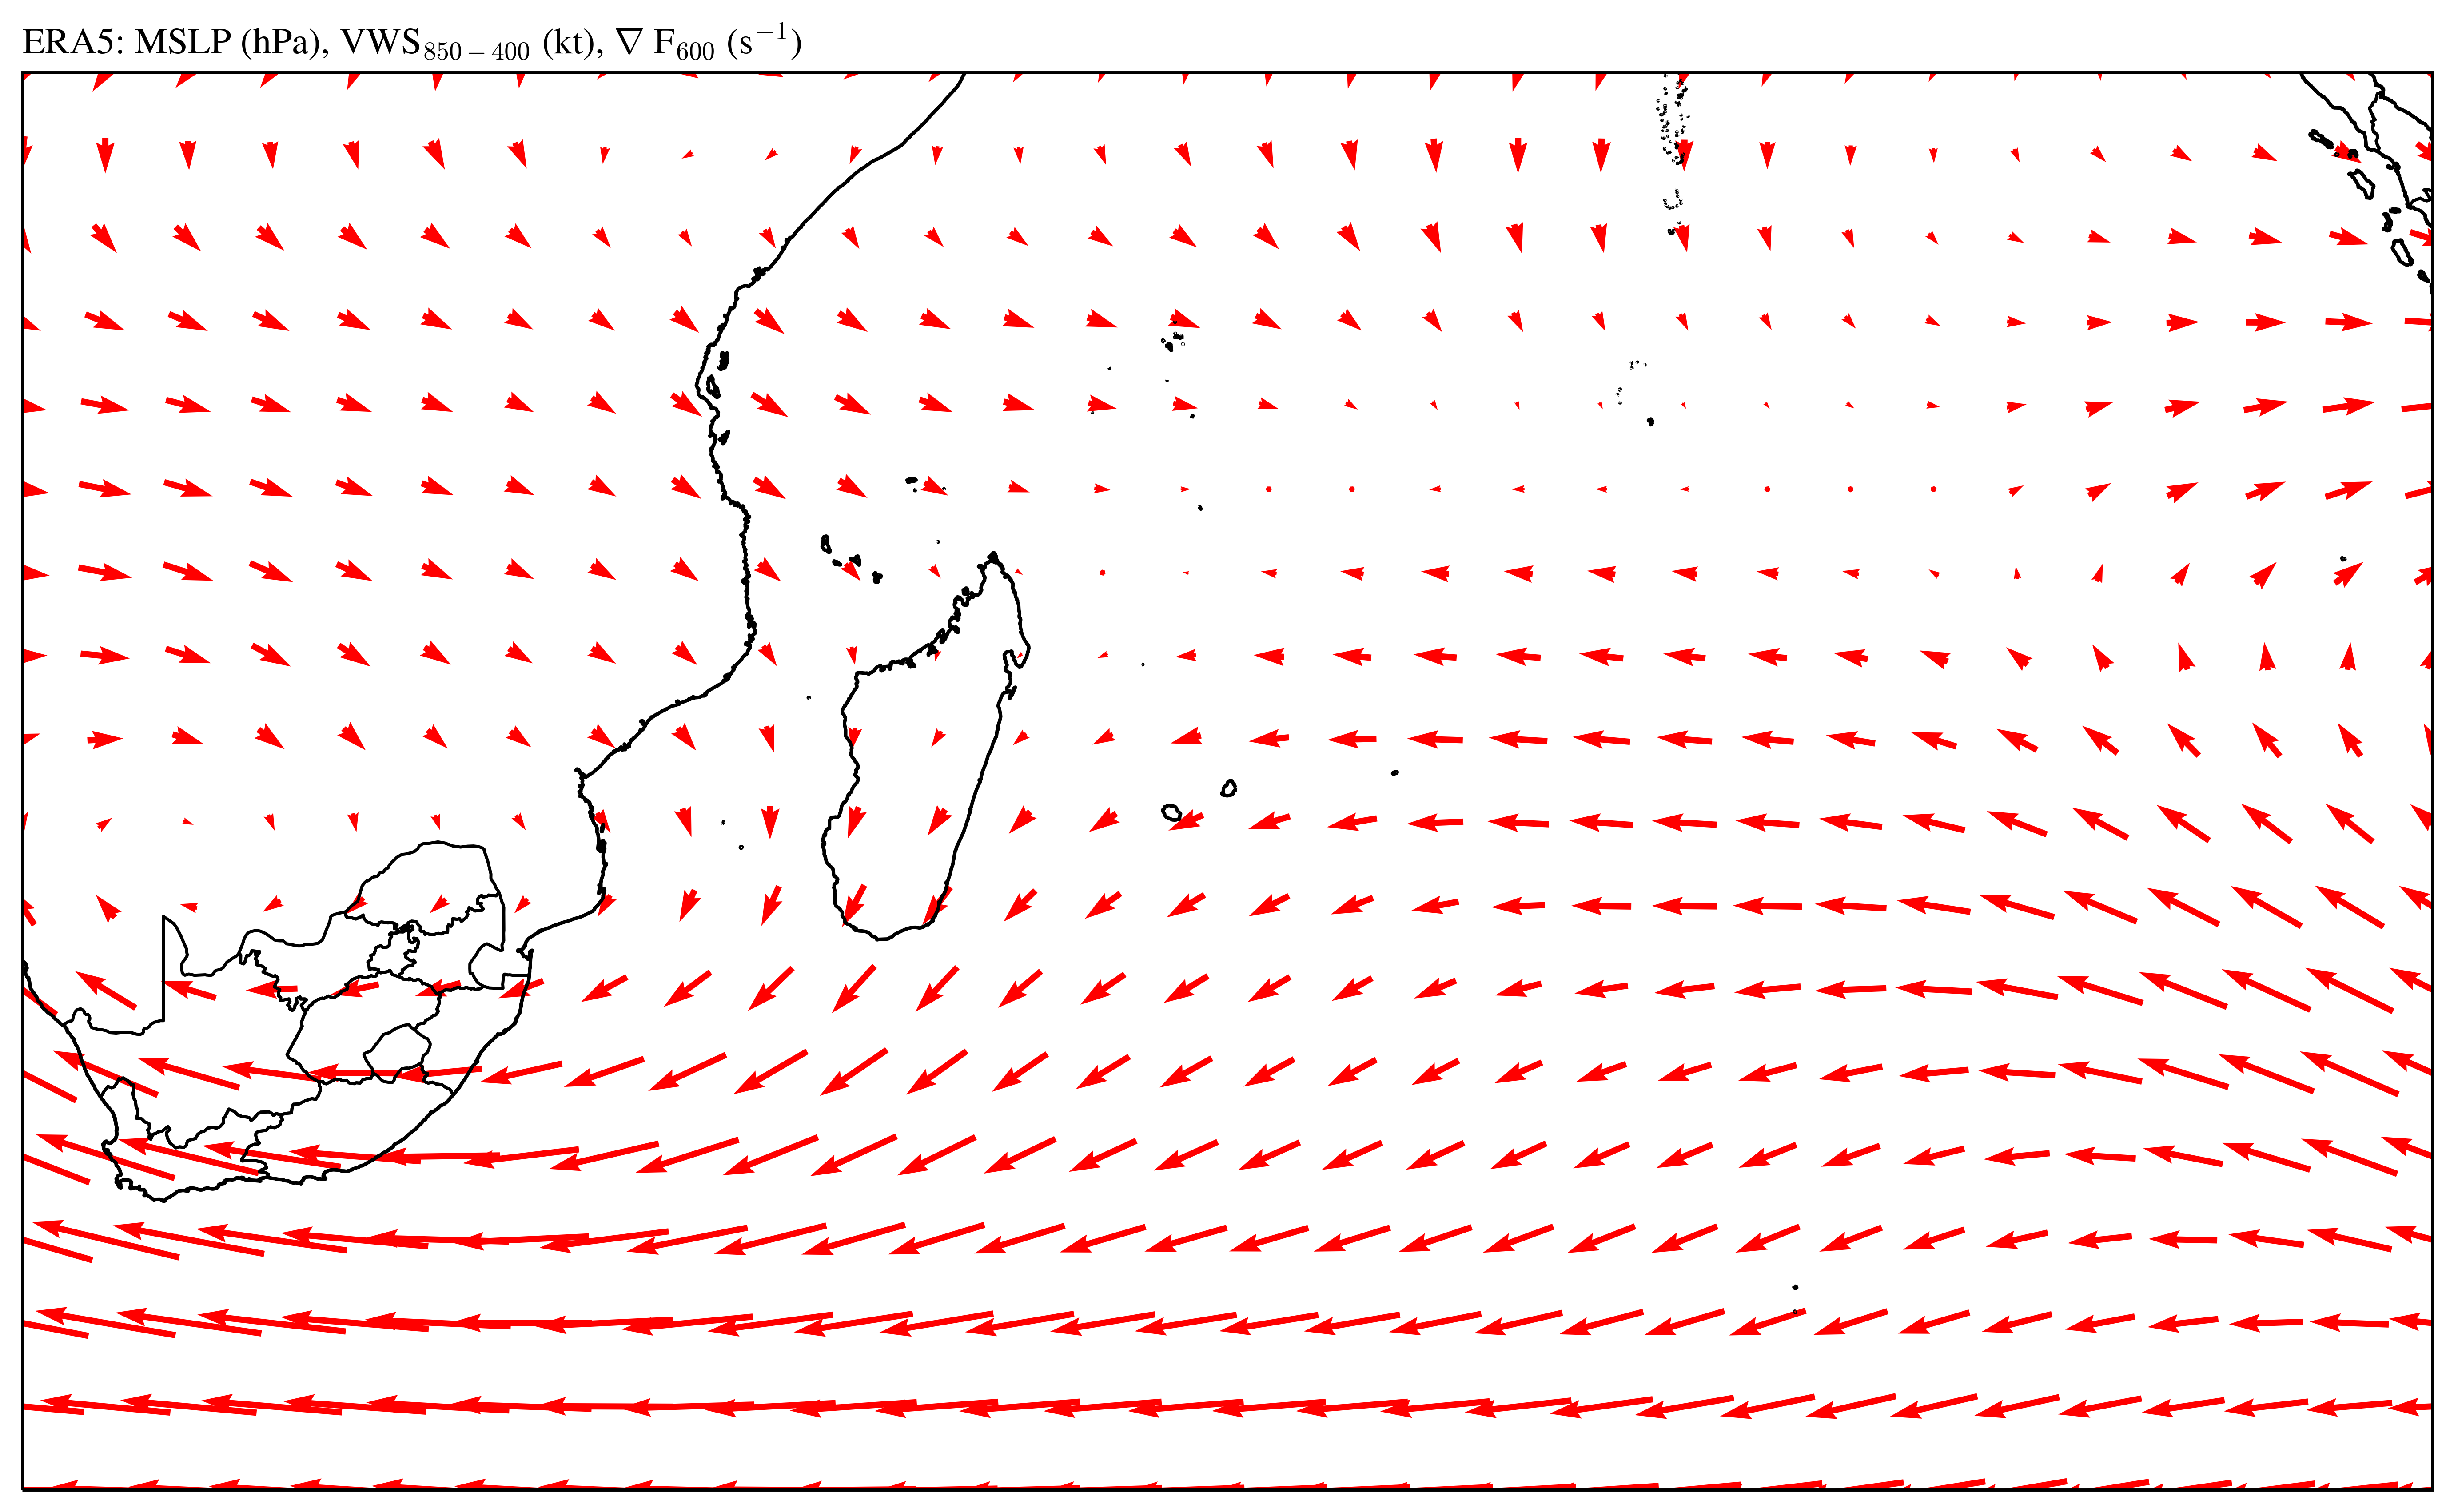

In [44]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([15, 100, -45, 5], mapcrs)

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot Divergence at 600 hPa
#div_range = np.arange(-0.000040, 0.0000245, 0.0000005)
#fmt = '%1.5f'
#dive = ax.contourf(lons, lats, diverge, div_range, cmap='PuOr',
#                 transform=datacrs)
#cbar = plt.colorbar(dive, orientation='vertical', pad=0.01, aspect=35, shrink=0.542, 
#                    ticks=[-0.000040, -0.000032, -0.000024, -0.000016, -0.000008, 0.000000,
#                           0.000008, 0.000016, 0.000024], format=fmt)
#cbar.ax.set_yticklabels(['-4.0','-3.2', '-2.4', '-1.6', '-0.8', 
#                         '0.0', '0.8', '1.6', '2.4'])
#cbar.ax.minorticks_on()
#cbar.ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
#cbar.ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Plot 850-400 hPa Wind Shear; Either difference
ax.quiver(lons, lats, uwnd_shear, vwnd_shear, color='red', 
         pivot='middle', regrid_shape=18, transform=datacrs)

# Or Individual wind layer profiles
#ax.barbs(lons, lats, uwnd_850, vwnd_850, color='red', 
          #pivot='tip', regrid_shape=17, transform=datacrs, length=6.5)

#ax.barbs(lons, lats, uwnd_400, vwnd_400, color='blue', 
          #pivot='tip', regrid_shape=17, transform=datacrs, length=6.5)

# Plot MSLP Contour
#MSLP_range = np.arange(995, 1010, 1)
#prs = ax.contour(lons, lats, mslp_hpa, MSLP_range, colors='k',
#                 transform=datacrs, zorder=1)
#ax.clabel(prs, fmt='%d')

# Plot Highs and Lows (Min/Max) values of MSLP
#plot_maxmin_points(lons, lats, mslp_hpa, 'max', 60, symbol='H', color='b', transform=datacrs)
#plot_maxmin_points(lons, lats, mslp_hpa, 'min', 20, symbol='L', color='r', transform=datacrs)

# Create a line(s) that highlights the surface trough
#point1 = dict(lon=120.90, lat=17.50)
#point2 = dict(lon=120.25, lat=13.50)
#lon_p = [point1['lon'], point2['lon']]
#lat_p = [point1['lat'], point2['lat']]
#ax.plot(lon_p, lat_p, color='red', linewidth=2.5, transform=ccrs.Geodetic())

#point3 = dict(lon=120.25, lat=13.50)
#point4 = dict(lon=122.40, lat=10.40)
#lon_p1 = [point3['lon'], point4['lon']]
#lat_p1 = [point3['lat'], point4['lat']]
#ax.plot(lon_p1, lat_p1, color='red', linewidth=2.5, transform=ccrs.Geodetic())

# Make some nice titles for the plot (one right, one left)
plt.title(r'ERA5: MSLP (hPa), VWS$_{850-400}$ (kt), $\nabla$ F$_{600}$ (s$^{-1}$)', 
          loc='left')
#plt.title('Time: {} UTC'.format(cftime), loc='right')

# Set X and Y-ticks for Latitude and Longitude Coordinates
#ax.set_yticks(lats, 10, crs=ccrs.PlateCarree())
#ax.set_xticks(lons, 10, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
#ax.set_xticks(ax.get_xticks()[1:7]) #Hide end points of longitude tickmarks
#ax.set_yticks(ax.get_yticks()[1:5]) #Hide end points of latitude tickmarks
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('MSLP, Div F, VWS.jpg', bbox_inches="tight")
plt.show()

AttributeError: Neither Quantity object nor its magnitude ([11.76145   11.610716  11.366124  11.069396  10.73653   10.374374
  9.990425   9.603434   9.2494     8.977549   8.8343725  8.843161
  8.988741   9.217157   9.457447   9.658305   9.817813   9.982072
 10.211342  10.540185  10.961715  11.442076  11.943755  12.435857
 12.892054  13.290245  13.620987  13.896468  14.145594  14.393271
 14.640764  14.863077  15.022722  15.089479  15.053554  14.924463
 14.719637  14.455637  14.148441  13.8188095 13.492761  13.193532
 12.93287   12.711597  12.525603  12.369445  12.235511  12.112674
 11.989282  11.858392  11.71871   11.571717  11.418427  11.262119
 11.11369   10.989971  10.902715  10.8472    10.80286   10.746481
 10.667718  10.574404  10.483343  10.406844  10.348823  10.312155
 10.303482  10.325741  10.371916  10.434591  10.521024  10.655561
 10.86737   11.172155  11.561806  12.008779  12.4827795 12.964575
 13.442833  13.886144  14.184087 ]) has attribute 'values'

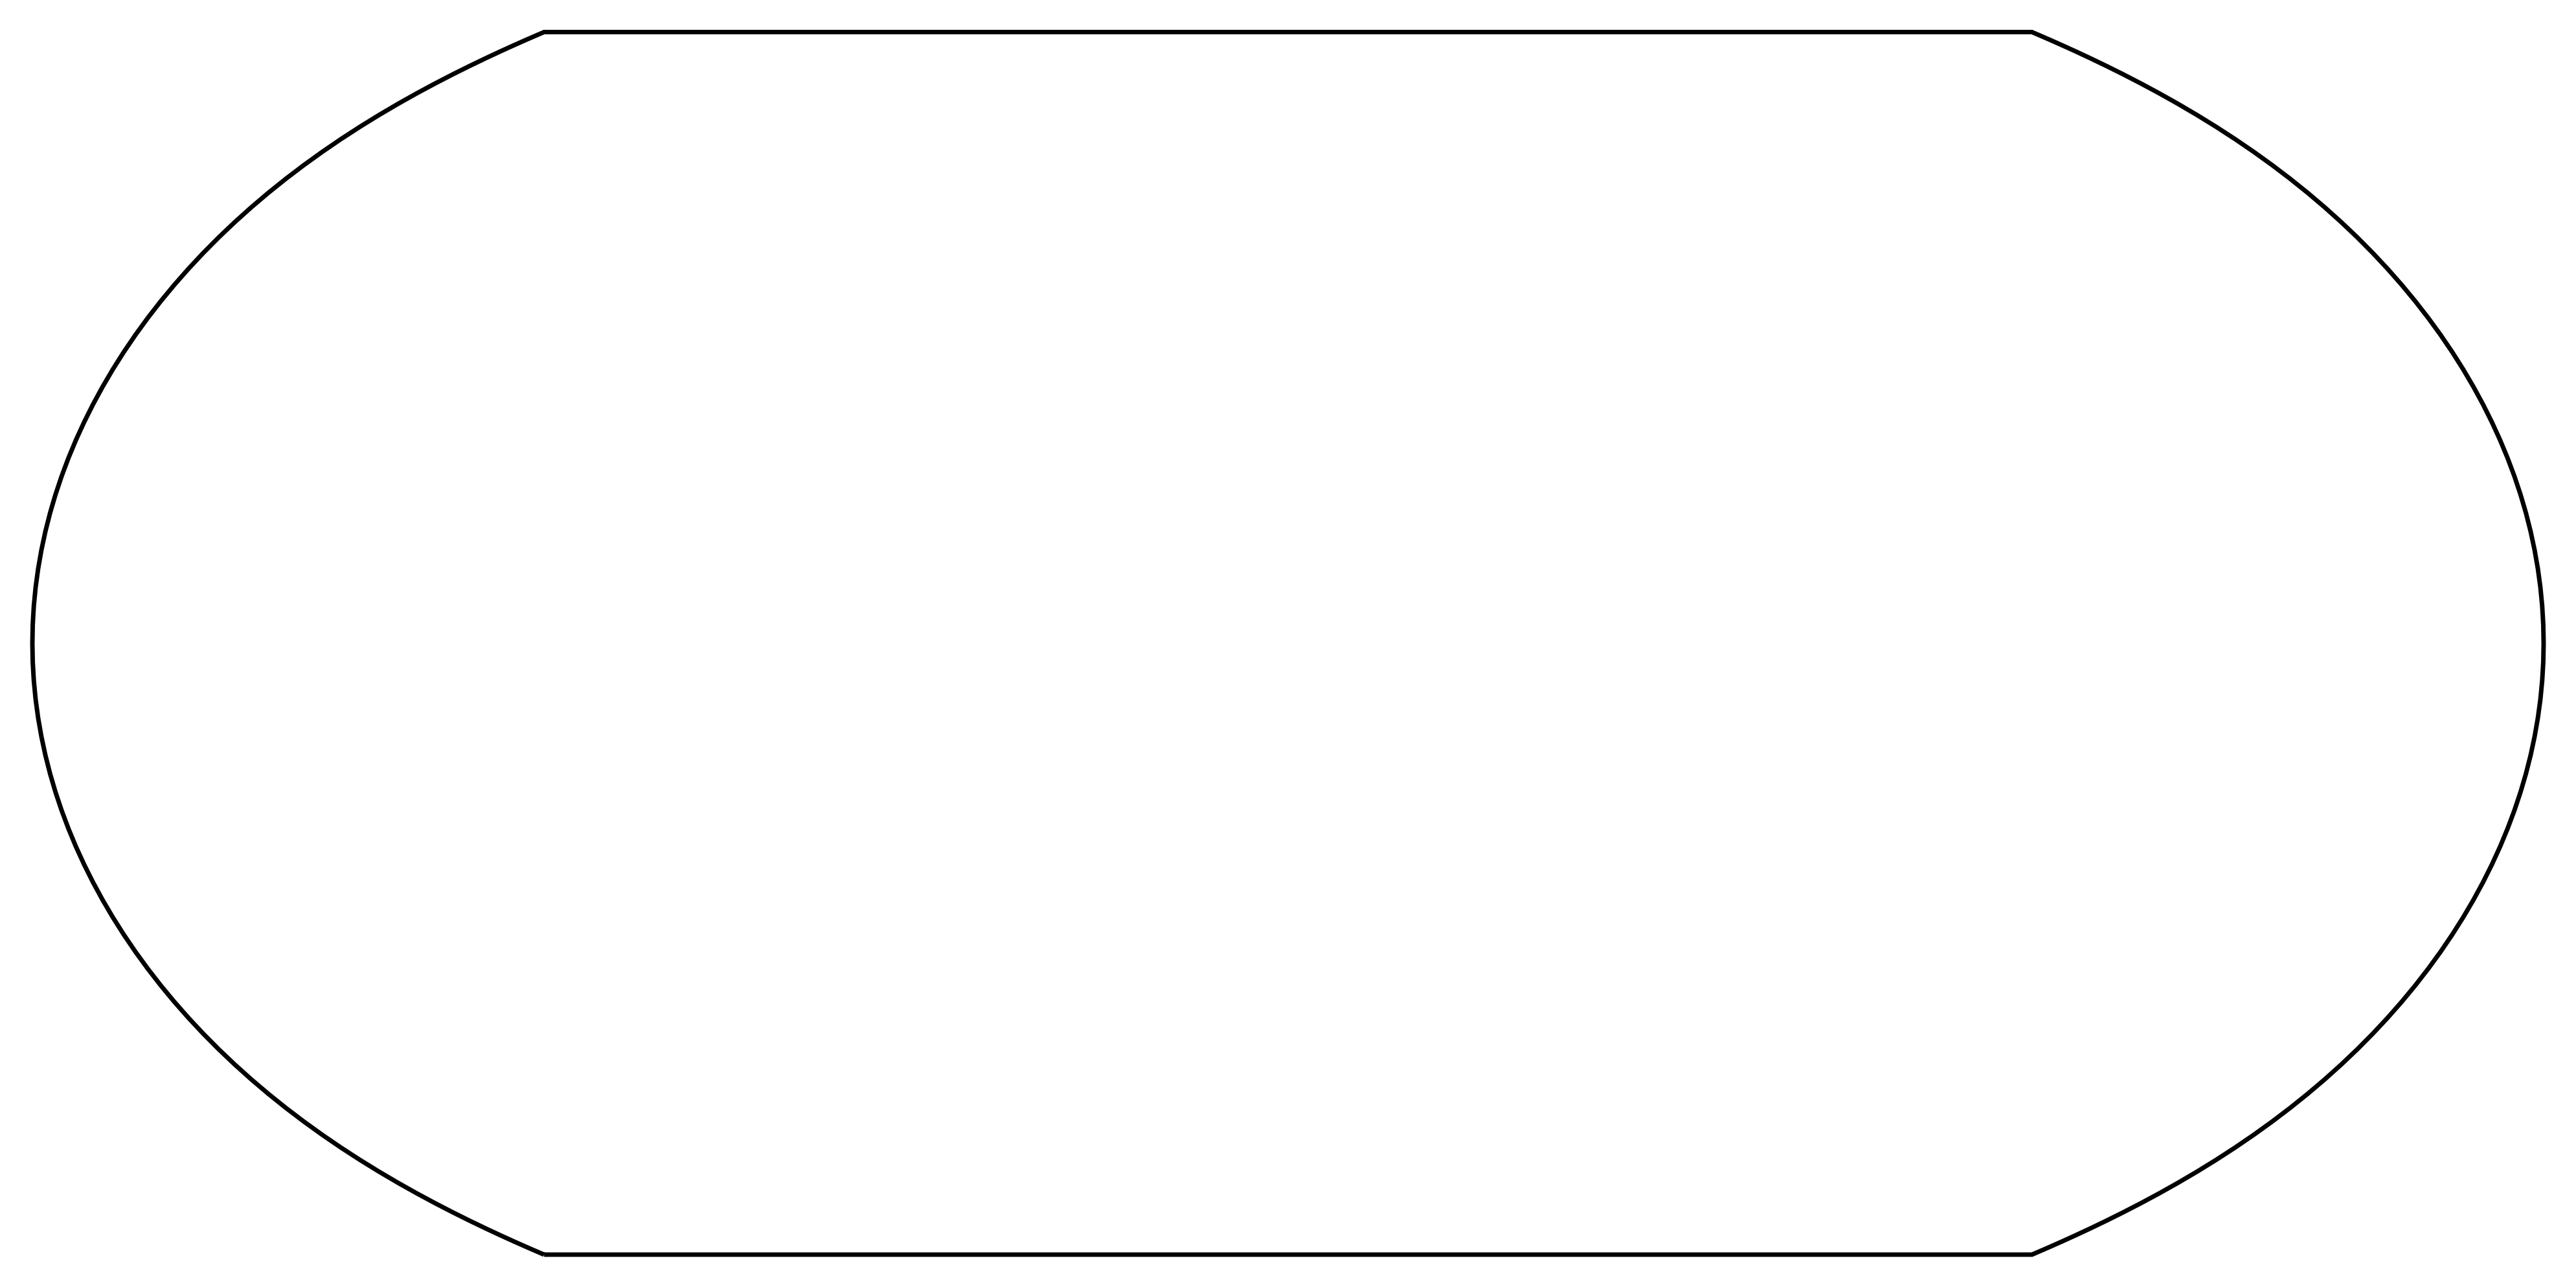

In [55]:
# Import the tools we are going to need today:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

# Grab lat/lon values (NAM will be 2D)
lats = ds1.lat
lons = ds1.lon
lev = ds1.plev

# Select and grab data
#mslp = ds['msl']
#div = ds1['d']
u_wind = ds1['ua']
v_wind = ds2['va']

# Select U and V-components at 850 hPa
uwnd_850 = gaussian_filter(u_wind.sel(plev=85000).data[0], sigma=1.0) * units('m/s')
vwnd_850 = gaussian_filter(v_wind.sel(plev=85000).data[0], sigma=1.0) * units('m/s')

# Select U and V-components at 400 hPa
uwnd_400 = gaussian_filter(u_wind.sel(plev=20000).data[0], sigma=1.0) * units('m/s')
vwnd_400 = gaussian_filter(v_wind.sel(plev=20000).data[0], sigma=1.0) * units('m/s')

# Calculate U and V-wind shear components
u = uwnd_850[0] - uwnd_400[0]
v = vwnd_850[0] - vwnd_400[0]


ws = (u**2 + v**2)**0.5
ax = plt.axes(projection=ccrs.EqualEarth())
strm = ax.streamplot(lons, lats, u, v, transform=ccrs.PlateCarree(),
                     density=4, color=ws.values(), cmap=plt.get_cmap('cool'))
plt.colorbar(strm.lines)
ax.coastlines(color='grey'); ax.gridlines(draw_labels=True);  # what is this line doing?